In [ ]:
import os
import glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import gc
import warnings

warnings.filterwarnings('ignore')

DATA_DIR = os.path.join('..', 'data')  
TICKERS = ['SOUN', 'FROG', 'CRWV']


In [ ]:
def load_and_flatten(folder_path):
    files = sorted(glob.glob(os.path.join(folder_path, '*.csv')))
    for file in files:
        print(f"Loading {file} ...")
        df = pd.read_csv(file)
        required_cols = ['ts_event','bid_px_00','ask_px_00','bid_sz_00','ask_sz_00','action']
        if not all(col in df.columns for col in required_cols):
            print(f"Skipping {file} due to missing columns")
            continue
        df = df[(df['bid_px_00'] > 0) & (df['ask_px_00'] > 0) & (df['bid_sz_00'] >= 0) & (df['ask_sz_00'] >= 0)]
        if df.empty:
            continue
        df['ts'] = pd.to_datetime(df['ts_event'], unit='ns', utc=True)
        df['bid_px_00'] = df['bid_px_00'].astype(float) / 1e9
        df['ask_px_00'] = df['ask_px_00'].astype(float) / 1e9
        df['midquote'] = (df['bid_px_00'] + df['ask_px_00']) / 2
        df['depth_00'] = df['bid_sz_00'].astype(int) + df['ask_sz_00'].astype(int)
        df['ticker'] = os.path.basename(folder_path)
        yield df

def load_all_data(data_dir, tickers=TICKERS):
    all_dfs = []
    for ticker in tickers:
        print(f"Processing ticker: {ticker}")
        folder = os.path.join(data_dir, ticker)
        dfs = []
        for df_part in load_and_flatten(folder):
            df_part['bid_sz_00'] = pd.to_numeric(df_part['bid_sz_00'], downcast='unsigned')
            df_part['ask_sz_00'] = pd.to_numeric(df_part['ask_sz_00'], downcast='unsigned')
            df_part['depth_00'] = pd.to_numeric(df_part['depth_00'], downcast='unsigned')
            df_part['midquote'] = df_part['midquote'].astype('float32')
            df_part['price'] = pd.to_numeric(df_part['price'], errors='coerce')
            df_part['size'] = pd.to_numeric(df_part['size'], errors='coerce')
            df_part = df_part.dropna(subset=['price','size'])
            dfs.append(df_part)
            del df_part
            gc.collect()
        if dfs:
            ticker_df = pd.concat(dfs, ignore_index=True)
            all_dfs.append(ticker_df)
            del dfs
            gc.collect()
    return pd.concat(all_dfs, ignore_index=True) if all_dfs else pd.DataFrame()


In [3]:
print("Loading L2 data for all tickers...")
df = load_all_data(DATA_DIR)
print(f"Total rows loaded: {len(df)}")
print(df.head())


Loading L2 data for all tickers...
Processing ticker: SOUN
Loading ..\data\SOUN\SOUN_2025-04-03 00_00_00+00_00.csv ...
Loading ..\data\SOUN\SOUN_2025-04-04 00_00_00+00_00.csv ...
Loading ..\data\SOUN\SOUN_2025-04-07 00_00_00+00_00.csv ...
Loading ..\data\SOUN\SOUN_2025-04-08 00_00_00+00_00.csv ...
Loading ..\data\SOUN\SOUN_2025-04-09 00_00_00+00_00.csv ...
Loading ..\data\SOUN\SOUN_2025-04-10 00_00_00+00_00.csv ...
Loading ..\data\SOUN\SOUN_2025-04-11 00_00_00+00_00.csv ...
Loading ..\data\SOUN\SOUN_2025-04-14 00_00_00+00_00.csv ...
Loading ..\data\SOUN\SOUN_2025-04-15 00_00_00+00_00.csv ...
Loading ..\data\SOUN\SOUN_2025-04-16 00_00_00+00_00.csv ...
Loading ..\data\SOUN\SOUN_2025-04-17 00_00_00+00_00.csv ...
Loading ..\data\SOUN\SOUN_2025-04-21 00_00_00+00_00.csv ...
Loading ..\data\SOUN\SOUN_2025-04-22 00_00_00+00_00.csv ...
Loading ..\data\SOUN\SOUN_2025-04-23 00_00_00+00_00.csv ...
Loading ..\data\SOUN\SOUN_2025-04-24 00_00_00+00_00.csv ...
Loading ..\data\SOUN\SOUN_2025-04-25 00_0

In [4]:
executions = df[df['action'] == 'T'].copy()
executions = executions[executions['size'] > 0]
executions['exec_price'] = executions['price'] / 1e9
executions['ts'] = pd.to_datetime(executions['ts_event'], unit='ns', utc=True)
if 'symbol' in executions.columns:
    executions['ticker'] = executions['symbol']

orderbook_updates = df[df['action'] != 'T'].copy()
orderbook_updates['ts'] = pd.to_datetime(orderbook_updates['ts_event'], unit='ns', utc=True)
if 'symbol' in orderbook_updates.columns:
    orderbook_updates['ticker'] = orderbook_updates['symbol']
print(f"Executions: {len(executions)}, Orderbook updates: {len(orderbook_updates)}")


Executions: 793814, Orderbook updates: 7182820


In [5]:
merged_list = []
for ticker in TICKERS:
    exec_t = executions[executions['ticker'] == ticker].sort_values('ts').reset_index(drop=True)
    book_t = orderbook_updates[orderbook_updates['ticker'] == ticker].sort_values('ts').drop_duplicates('ts').reset_index(drop=True)
    if exec_t.empty or book_t.empty:
        continue
    merged_t = pd.merge_asof(
        left=exec_t,
        right=book_t[['ts','midquote','depth_00']],
        on='ts', direction='backward',
        tolerance=pd.Timedelta('1s'),
        suffixes=('_exec','_book'),
        allow_exact_matches=False
    ).dropna(subset=['midquote_book'])
    merged_t = merged_t[merged_t['depth_00_book'] > 0]
    merged_list.append(merged_t)
merged = pd.concat(merged_list, ignore_index=True)
merged['slippage'] = (merged['exec_price'] - merged['midquote_book']) / merged['midquote_book']


In [6]:
Q_low, Q_hi = merged['slippage'].quantile([0.01, 0.99])
filtered_merged = merged[(merged['slippage'] >= Q_low) & (merged['slippage'] <= Q_hi)].copy()
filtered_merged = filtered_merged[filtered_merged['size'] > 0]
filtered_merged['log_size'] = np.log(filtered_merged['size'])
filtered_merged['log_slip'] = np.log(np.abs(filtered_merged['slippage']) + 1e-8)
filtered_merged = filtered_merged.dropna(subset=['log_size', 'log_slip'])
print(f"Filtered data points: {len(filtered_merged)}")


Filtered data points: 694692


In [7]:
def fit_rolling_powerlaw(data, gamma_fixed=0.5, window='5min', min_points=10, var_thresh=1e-8):
    data = data.sort_values('ts')
    alphas = {}
    count_print = 0
    for window_start in pd.date_range(data['ts'].min(), data['ts'].max(), freq=window):
        window_end = window_start + pd.Timedelta(window)
        group = data[(data['ts'] >= window_start) & (data['ts'] < window_end)]
        if len(group) < min_points or group['log_size'].var() < var_thresh:
            continue
        slip_median = group['log_slip'].median()
        slip_mad = (group['log_slip'] - slip_median).abs().mean()
        group_filtered = group[
            (group['log_slip'] >= slip_median - 4*slip_mad) &
            (group['log_slip'] <= slip_median + 4*slip_mad)
        ]
        if len(group_filtered) < min_points: continue
        X = sm.add_constant(group_filtered['log_size'])
        y = group_filtered['log_slip']
        try:
            model = sm.RLM(y, X).fit()
        except Exception: continue
        if 'const' not in model.params: continue
        alpha_value = np.exp(model.params['const'])
        if np.isnan(alpha_value) or alpha_value <= 0: continue
        alphas[window_start] = alpha_value
        if count_print < 10:
            print(f"{window_start}: alpha={alpha_value:.5f} on {len(group_filtered)} pts")
            count_print += 1
    return pd.Series(alphas).sort_index()

alpha_series = fit_rolling_powerlaw(filtered_merged)


2025-04-03 13:30:00.016252285+00:00: alpha=0.00086 on 2520 pts
2025-04-03 13:35:00.016252285+00:00: alpha=0.00060 on 2133 pts
2025-04-03 13:40:00.016252285+00:00: alpha=0.00065 on 1373 pts
2025-04-03 13:45:00.016252285+00:00: alpha=0.00044 on 894 pts
2025-04-03 13:50:00.016252285+00:00: alpha=0.00056 on 896 pts
2025-04-03 13:55:00.016252285+00:00: alpha=0.00060 on 618 pts
2025-04-03 14:00:00.016252285+00:00: alpha=0.00028 on 903 pts
2025-04-03 14:05:00.016252285+00:00: alpha=0.00066 on 664 pts
2025-04-03 14:10:00.016252285+00:00: alpha=0.00010 on 628 pts
2025-04-03 14:15:00.016252285+00:00: alpha=0.00058 on 565 pts


In [8]:
import pickle

if not alpha_series.empty:
    with open('alpha_series.pkl', 'wb') as f:
        pickle.dump(alpha_series, f)
    print(f"Saved alpha_series.pkl with {len(alpha_series)} valid minute-level fits.")
else:
    print("Alpha series empty, nothing saved.")


Saved alpha_series.pkl with 1638 valid minute-level fits.


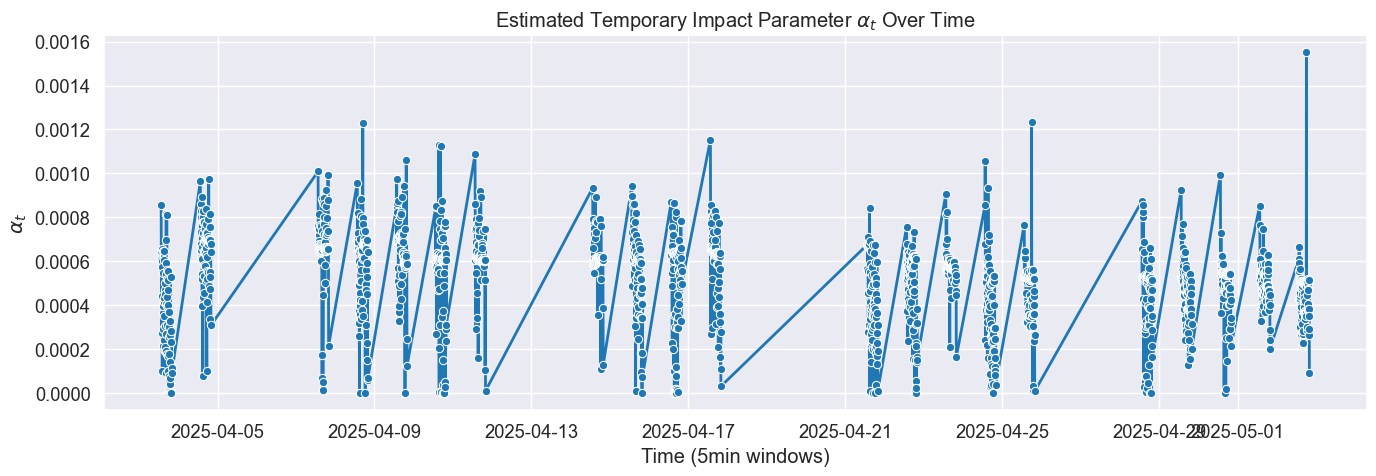

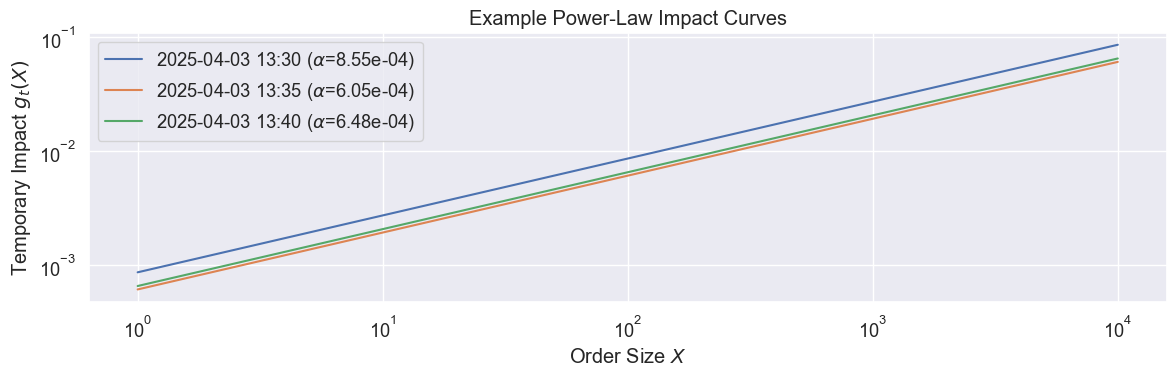

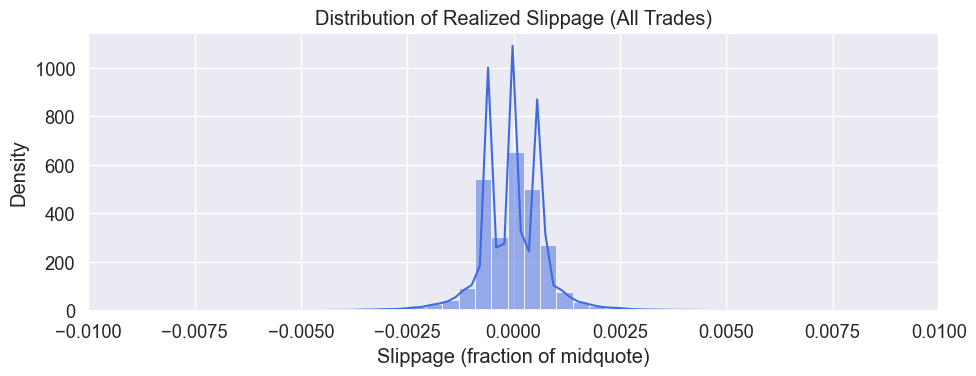

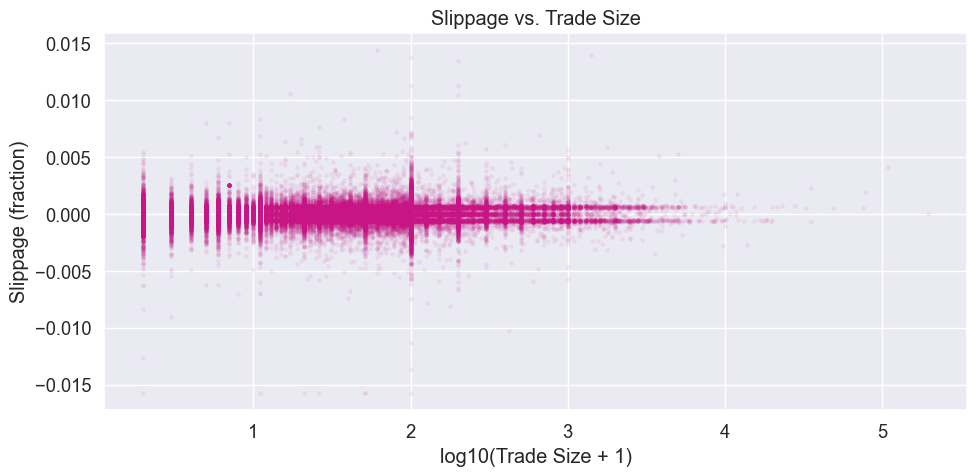

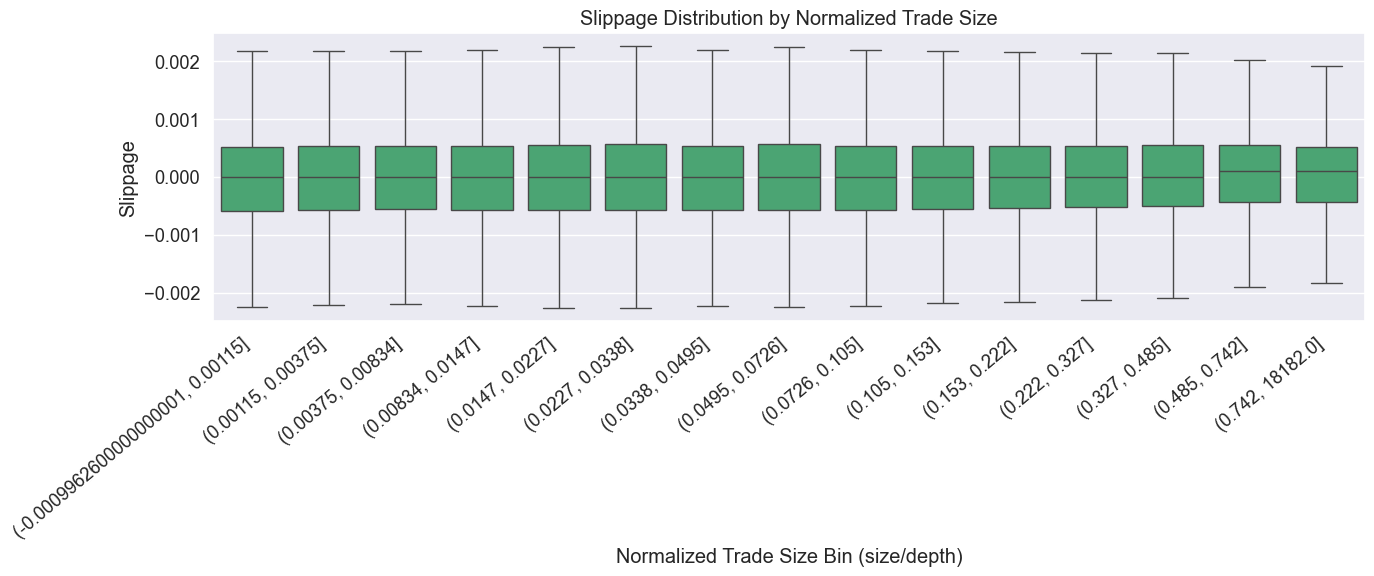

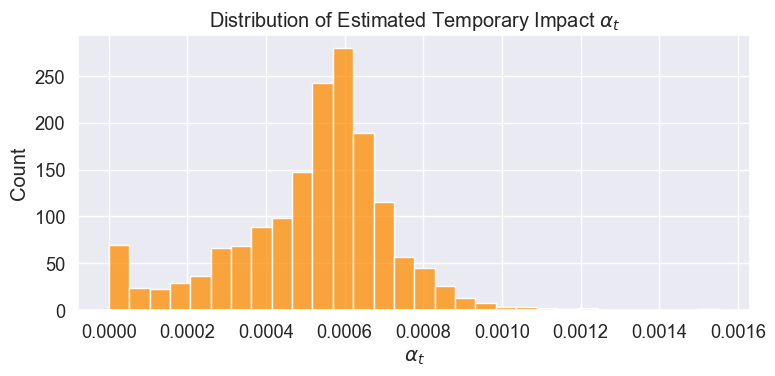

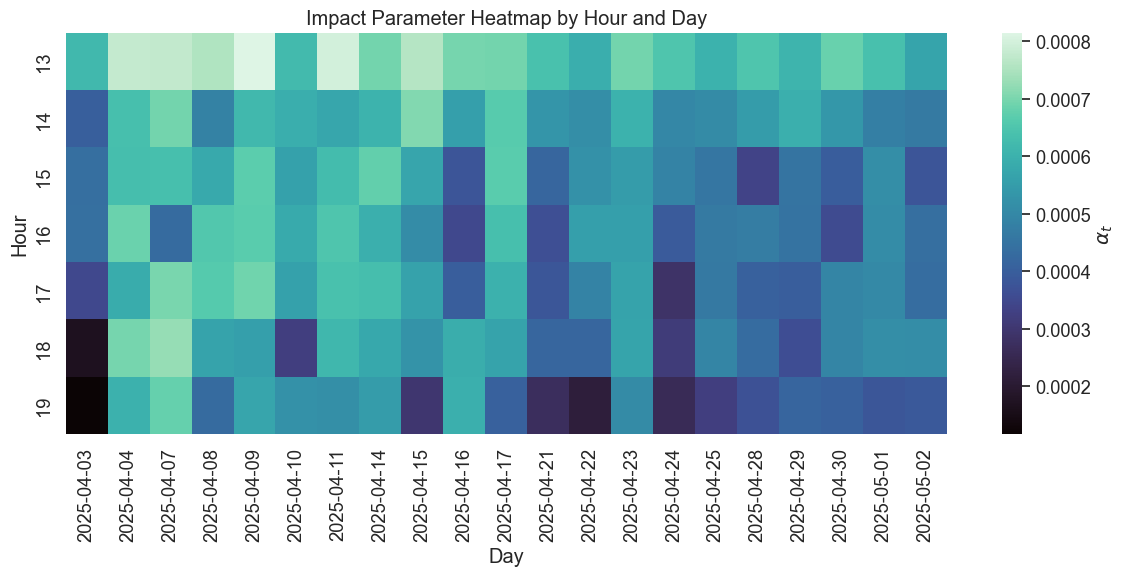

In [9]:

sns.set(style="darkgrid", context="notebook", font_scale=1.2)

# --- 1. Time Series Plot of Alpha ---
plt.figure(figsize=(14, 5))
sns.lineplot(x=alpha_series.index, y=alpha_series.values, marker="o", linewidth=2, color='tab:blue')
plt.title(r"Estimated Temporary Impact Parameter $\alpha_t$ Over Time")
plt.xlabel("Time (5min windows)")
plt.ylabel(r"$\alpha_t$")
plt.tight_layout()
plt.show()

# --- 2. Example Power-law Impact Curves ---
plt.figure(figsize=(12,4))
for idx, time in enumerate(alpha_series.index[:3]):
    alpha_val = alpha_series.iloc[idx]
    sizes = np.logspace(0, 4, 100)
    impacts = alpha_val * sizes ** 0.5
    plt.loglog(sizes, impacts, label=f"{str(time)[:16]} ($\\alpha$={alpha_val:.2e})")
plt.title(r'Example Power-Law Impact Curves')
plt.xlabel('Order Size $X$')
plt.ylabel('Temporary Impact $g_t(X)$')
plt.legend()
plt.tight_layout()
plt.show()

# --- 3. Distribution of Realized Slippage ---
plt.figure(figsize=(10,4))
sns.histplot(merged['slippage'], bins=100, color='royalblue', edgecolor='w', kde=True, stat="density")
plt.xlim(-0.01, 0.01)
plt.title("Distribution of Realized Slippage (All Trades)")
plt.xlabel("Slippage (fraction of midquote)")
plt.tight_layout()
plt.show()

# --- 4. Slippage vs log(Trade Size): Density Scatter ---
sample = merged.sample(80000, random_state=21) if len(merged)>80000 else merged
plt.figure(figsize=(10,5))
sns.scatterplot(
    x=np.log10(sample['size'] + 1),
    y=sample['slippage'],
    alpha=0.08, s=8, color="mediumvioletred", edgecolor=None)
plt.xlabel("log10(Trade Size + 1)")
plt.ylabel("Slippage (fraction)")
plt.title("Slippage vs. Trade Size")
plt.grid(True)
plt.tight_layout()
plt.show()

# --- 5. Boxplot: Slippage by Normalized Trade Size ---
merged['norm_size'] = merged['size'] / merged['depth_00_book']
merged['norm_size_bin'] = pd.qcut(merged['norm_size'], q=15, duplicates='drop')
plt.figure(figsize=(14,6))
sns.boxplot(
    data=merged, x='norm_size_bin', y='slippage',
    showfliers=False, color='mediumseagreen')
plt.title('Slippage Distribution by Normalized Trade Size')
plt.xlabel('Normalized Trade Size Bin (size/depth)')
plt.ylabel('Slippage')
plt.xticks(rotation=40, ha='right')
plt.tight_layout()
plt.show()

# --- 6. Histogram: Distribution of Fitted Alpha ---
plt.figure(figsize=(8,4))
sns.histplot(alpha_series, bins=30, color='darkorange', edgecolor='w')
plt.title(r'Distribution of Estimated Temporary Impact $\alpha_t$')
plt.xlabel(r'$\alpha_t$')
plt.tight_layout()
plt.show()


try:
    alpha_df = alpha_series.reset_index()
    alpha_df.columns = ['timestamp', 'alpha']
    if hasattr(alpha_df['timestamp'].iloc[0],'hour'):
        alpha_df['hour'] = alpha_df['timestamp'].dt.hour
        alpha_df['date'] = alpha_df['timestamp'].dt.date
        alpha_pivot = alpha_df.pivot_table(index='hour', columns='date', values='alpha')
        plt.figure(figsize=(12, 6))
        sns.heatmap(alpha_pivot, cmap="mako", cbar_kws={'label': r'$\alpha_t$'})
        plt.title("Impact Parameter Heatmap by Hour and Day")
        plt.xlabel("Day")
        plt.ylabel("Hour")
        plt.tight_layout()
        plt.show()
except Exception as e:
    print("Alpha time coverage not suitable for heatmap.")
